In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

In [120]:
import sys

### Reading data

In [122]:
DATA_FOLDER = './data/'

In [123]:
openfood_file = "en.openfoodfacts.org.products.csv"
openfood = pd.read_csv(DATA_FOLDER + openfood_file, sep = '\t')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Remembering Research question

2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

The first decision is to narrow down the search, just for Switzerland products

In [178]:
foodSwitzerland = openfood[openfood['countries_tags']=="en:switzerland"]

In [179]:
nbProdSwit = len(foodSwitzerland)
print("Number of products: ", nbProdSwit)
foodSwitzerland.head()

Number of products:  13454


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
285,0000003301098,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1527593074,2018-05-29T11:24:34Z,1527593109,2018-05-29T11:25:09Z,Mini cuchaule au beurre,NaN,100 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,0000013000004,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1484431999,2017-01-14T22:13:19Z,1484432028,2017-01-14T22:13:48Z,Kochspeck,NaN,686 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,00025393,http://world-en.openfoodfacts.org/product/0002...,openfoodfacts-contributors,1530019114,2018-06-26T13:18:34Z,1530019311,2018-06-26T13:21:51Z,Salade de lentilles,NaN,200 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,0007200000021,http://world-en.openfoodfacts.org/product/0007...,date-limite-app,1418991821,2014-12-19T12:23:41Z,1442754589,2015-09-20T13:09:49Z,Sauce bolognaise,NaN,420 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,0010000002218,http://world-en.openfoodfacts.org/product/0010...,date-limite-app,1442659864,2015-09-19T10:51:04Z,1461430836,2016-04-23T17:00:36Z,Ikea Lachs,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. A first perspective: Compare old vs new products inside the dataset

_Assumption: Given two products, if the description of the first product was uploaded earlier to the dataset than the description of the second product, then the first product was earlier in the market than the second product._

A first perspective to tackle the research question, is to compare how in this more than 6 years of existance of the dataset, the characteristics of the products have changed. Specifically, we would like to know if there have been some changes in the origin of the primary resources, or in the origin of the manufacture or in the labels of the products.

The study of the evolution in time of each one of those features, will include an __exploratory data analysis__, and will calculate the __correlation__ between each feature and the time.
Finally, a study including the three features will be done, aiming to find an aggregated differentiated behavior in time, reflected in different clusters of periods of time. For that the __K-modes algorithm__ will be used.

In [163]:
print("Date of first upload: ", min(foodSwitzerland['created_datetime']))
print("Date of last upload retrieved: ", max(foodSwitzerland['created_datetime']))

Date of first upload:  2012-05-16T18:33:35Z
Date of last upload retrieved:  2018-11-23T08:40:49Z


In [180]:
foodSwitzerland['created_datetime'] = pd.to_datetime(foodSwitzerland['created_datetime'])
foodSwitzerland = foodSwitzerland.sort_values(by='created_datetime')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The uploads of products sold in Switzerland, behaves differently in time. Taking into account the histogram presented below, three periods of time are defined:
- Period 1: Created for studying the behaviour "before". Goes from May 2012, until Jan 2017
- Period 2: Includes most of the points. Just includes Feb 2017. 
- Period 3: reated for studying the behaviour "after". Goes from March 2017, until Nov 2018

33.3% of data before:  2017-02-07 20:17:49
66.6% of data before:  2017-02-07 22:28:19
All data before: 2018-11-23 08:40:49


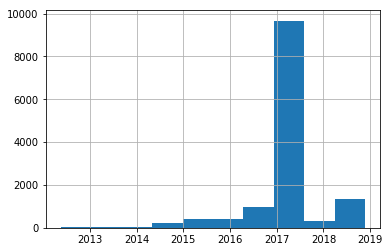

In [128]:
delta_period = int(len(foodSwitzerland)/3)
print("33.3% of data before: ", foodSwitzerland['created_datetime'].iloc[delta_period])
print("66.6% of data before: ", foodSwitzerland['created_datetime'].iloc[2*delta_period])
print("All data before:", max(foodSwitzerland['created_datetime']))
foodSwitzerland['created_datetime'].hist()

Before making subdivision of data:

In [347]:
filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'
filter_local = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra|[Ll]ocal'

place = pd.Series(['Other country','Switzerland', 'No information'], index=[0,1,2])
refLabel = pd.Series(['Other Label','Related with Switzerland', 'No information'], index=[0,1,2]) 

foodSwitzerland["originsCat"] = foodSwitzerland["origins"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["manuCat"] = foodSwitzerland["manufacturing_places"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["labCat"] = foodSwitzerland["labels_tags"].str.contains(filter_local,regex=True).map(refLabel,na_action='ignore')

Now, let's do the subdivision in the three periods:

In [348]:
foodSwitzerlandBef = foodSwitzerland[foodSwitzerland['created_datetime']<"2017-02-01 00:00:00"]
print("Number of observations: ", len(foodSwitzerlandBef))

Number of observations:  2294


In [349]:
foodSwitzerlandDur = foodSwitzerland[foodSwitzerland['created_datetime']>="2017-02-01 00:00:00"]
foodSwitzerlandDur = foodSwitzerlandDur[foodSwitzerlandDur['created_datetime']<"2017-03-01 00:00:00"]
print("Number of observations: ", len(foodSwitzerlandDur))

Number of observations:  9126


In [350]:
foodSwitzerlandAft = foodSwitzerland[foodSwitzerland['created_datetime']>="2017-03-01 00:00:00"]
print("Number of observations: ", len(foodSwitzerlandAft))

Number of observations:  2034


### 2.1. Study of the evolution in time of each one of the interest features

### 2.1.1 With respect to: Origin of the primary resources

First, bootstrapping for include confidence intervals to results

In [338]:
#Define vectores to store results
pearson_100ite = np.zeros (100)
pearsonNoNan_100ite = np.zeros (100)
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#during
propSD_100ite = np.zeros (100)
propOCD_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["originsCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #during
    temp_dur = foodSwitzerlandDur["originsCat"].sample(n=len(foodSwitzerlandDur), replace=True)
    propSD_100ite[iteration] = sum(temp_dur=="Switzerland")/len(foodSwitzerlandDur)
    propOCD_100ite[iteration] = sum(temp_dur=="Other country")/len(foodSwitzerlandDur)
    #after
    temp_aft = foodSwitzerlandAft["originsCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropD = propSB_100ite[iteration]-propOCD_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]
    pearson_100ite[iteration] = np.corrcoef([difpropB,difpropD,difpropA],[1,2,3])[0][1]
    ##scale so Nan effect is not a problem
    minB = min(propSB_100ite[iteration],propOCB_100ite[iteration])
    minD = min(propSD_100ite[iteration],propOCD_100ite[iteration])
    minA = min(propSA_100ite[iteration],propOCA_100ite[iteration])
    pearsonNoNan_100ite[iteration] = np.corrcoef([difpropB/minB,difpropD/minD,difpropA/minA],[1,2,3])[0][1]

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SDstd = propSD_100ite.std()
OCDstd = propOCD_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

Then, plotting of behavior 

There was not information for  1951  products in the period 1.
There was not information for  8826  products in the period 2.
There was not information for  1935  products in the period 3.


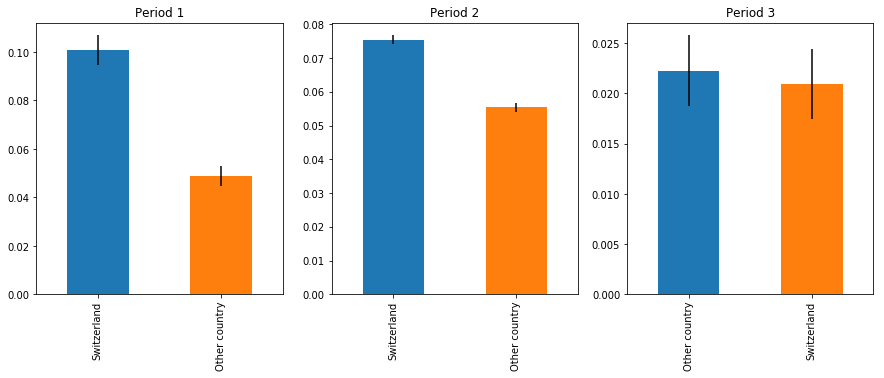

In [336]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["originsCat"])-sum(foodSwitzerlandBef["originsCat"]=="Switzerland")-sum(foodSwitzerlandBef["originsCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandDur["originsCat"])-sum(foodSwitzerlandDur["originsCat"]=="Switzerland")-sum(foodSwitzerlandDur["originsCat"]=="Other country")," products in the period 2.")
print("There was not information for ",len(foodSwitzerlandAft["originsCat"])-sum(foodSwitzerlandAft["originsCat"]=="Switzerland")-sum(foodSwitzerlandAft["originsCat"]=="Other country")," products in the period 3.")

#Plot origin of primary resources by periods
plt.subplot(1,3,1)

xB = [foodSwitzerlandBef["originsCat"].value_counts()[0], foodSwitzerlandBef["originsCat"].value_counts()[1]]
xD = [foodSwitzerlandDur["originsCat"].value_counts()[0], foodSwitzerlandDur["originsCat"].value_counts()[1]]
xA = [foodSwitzerlandAft["originsCat"].value_counts()[1], foodSwitzerlandAft["originsCat"].value_counts()[0]]

(foodSwitzerlandBef["originsCat"].value_counts()/len(foodSwitzerlandBef["originsCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,3,2)
(foodSwitzerlandDur["originsCat"].value_counts()/len(foodSwitzerlandBef["originsCat"])).plot(kind='bar', yerr = [SDstd,OCDstd],title='Period 2')
plt.subplot(1,3,3)
(foodSwitzerlandAft["originsCat"].value_counts()/len(foodSwitzerlandBef["originsCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 3')

plt.show()

Then, plotting of correlation

Median with NaN:  0.668246496304011
Median without NaN:  0.44205073079695356


Text(0.5, 1.0, 'Pearson Corr. No Nan Switzerland origin and Other country origin')

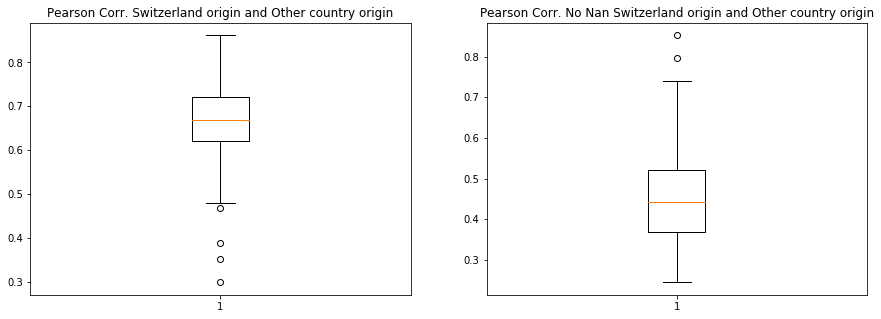

In [337]:
#Plot Correlation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplot(1,2,1)
print("Median with NaN: ",np.quantile(pearson_100ite,0.5))
plt.boxplot(pearson_100ite)
plt.title("Pearson Corr. Switzerland origin and Other country origin")

plt.subplot(1,2,2)
print("Median without NaN: ",np.quantile(pearsonNoNan_100ite,0.5))
plt.boxplot(pearsonNoNan_100ite)
plt.title("Pearson Corr. No Nan Switzerland origin and Other country origin")

### 2.1.2 With respect to: Manufacture

First, bootstrapping for include confidence intervals to results

In [340]:
#Define vectores to store results
pearson_100ite = np.zeros (100)
pearsonNoNan_100ite = np.zeros (100)
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#during
propSD_100ite = np.zeros (100)
propOCD_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["manuCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #during
    temp_dur = foodSwitzerlandDur["manuCat"].sample(n=len(foodSwitzerlandDur), replace=True)
    propSD_100ite[iteration] = sum(temp_dur=="Switzerland")/len(foodSwitzerlandDur)
    propOCD_100ite[iteration] = sum(temp_dur=="Other country")/len(foodSwitzerlandDur)
    #after
    temp_aft = foodSwitzerlandAft["manuCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropD = propSB_100ite[iteration]-propOCD_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]
    pearson_100ite[iteration] = np.corrcoef([difpropB,difpropD,difpropA],[1,2,3])[0][1]
    ##scale so Nan effect is not a problem
    minB = min(propSB_100ite[iteration],propOCB_100ite[iteration])
    minD = min(propSD_100ite[iteration],propOCD_100ite[iteration])
    minA = min(propSA_100ite[iteration],propOCA_100ite[iteration])
    pearsonNoNan_100ite[iteration] = np.corrcoef([difpropB/minB,difpropD/minD,difpropA/minA],[1,2,3])[0][1]

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SDstd = propSD_100ite.std()
OCDstd = propOCD_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

There was not information for  1530  products in the period 1.
There was not information for  8960  products in the period 2.
There was not information for  1869  products in the period 3.


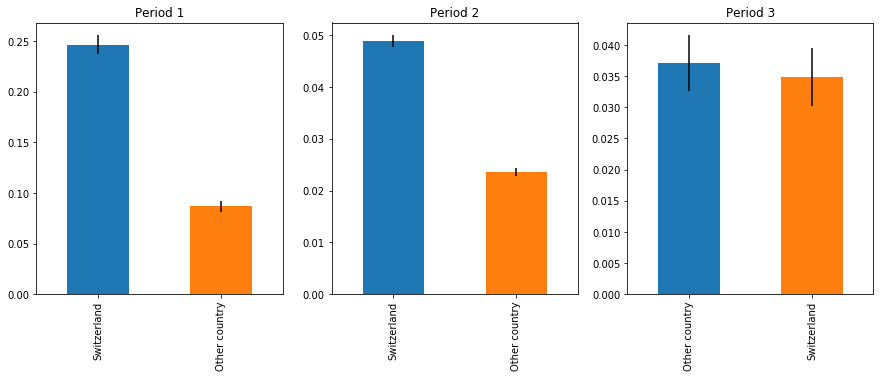

In [341]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["manuCat"])-sum(foodSwitzerlandBef["manuCat"]=="Switzerland")-sum(foodSwitzerlandBef["manuCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandDur["manuCat"])-sum(foodSwitzerlandDur["manuCat"]=="Switzerland")-sum(foodSwitzerlandDur["manuCat"]=="Other country")," products in the period 2.")
print("There was not information for ",len(foodSwitzerlandAft["manuCat"])-sum(foodSwitzerlandAft["manuCat"]=="Switzerland")-sum(foodSwitzerlandAft["manuCat"]=="Other country")," products in the period 3.")

#Plot origin of primary resources by periods
plt.subplot(1,3,1)

xB = [foodSwitzerlandBef["manuCat"].value_counts()[0], foodSwitzerlandBef["manuCat"].value_counts()[1]]
xD = [foodSwitzerlandDur["manuCat"].value_counts()[0], foodSwitzerlandDur["manuCat"].value_counts()[1]]
xA = [foodSwitzerlandAft["manuCat"].value_counts()[1], foodSwitzerlandAft["manuCat"].value_counts()[0]]

(foodSwitzerlandBef["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,3,2)
(foodSwitzerlandDur["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SDstd,OCDstd],title='Period 2')
plt.subplot(1,3,3)
(foodSwitzerlandAft["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 3')

plt.show()

Median with NaN:  0.5582136290790651
Median without NaN:  0.0833431394772422


Text(0.5, 1.0, 'Pearson Corr. No Nan Switzerland origin and Other country manufacture origin')

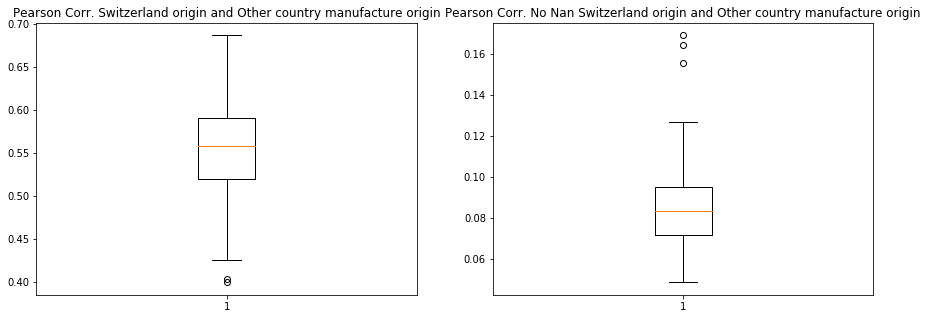

In [342]:
#Plot Correlation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplot(1,2,1)
print("Median with NaN: ",np.quantile(pearson_100ite,0.5))
plt.boxplot(pearson_100ite)
plt.title("Pearson Corr. Switzerland origin and Other country manufacture origin")

plt.subplot(1,2,2)
print("Median without NaN: ",np.quantile(pearsonNoNan_100ite,0.5))
plt.boxplot(pearsonNoNan_100ite)
plt.title("Pearson Corr. No Nan Switzerland origin and Other country manufacture origin")

### 2.1.3 With respect to: Labels

In [351]:
#Define vectores to store results
pearson_100ite = np.zeros (100)
pearsonNoNan_100ite = np.zeros (100)
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#during
propSD_100ite = np.zeros (100)
propOCD_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["labCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Related with Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other Label")/len(foodSwitzerlandBef)
    #during
    temp_dur = foodSwitzerlandDur["labCat"].sample(n=len(foodSwitzerlandDur), replace=True)
    propSD_100ite[iteration] = sum(temp_dur=="Related with Switzerland")/len(foodSwitzerlandDur)
    propOCD_100ite[iteration] = sum(temp_dur=="Other Label")/len(foodSwitzerlandDur)
    #after
    temp_aft = foodSwitzerlandAft["labCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Related with Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other Label")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropD = propSB_100ite[iteration]-propOCD_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]
    pearson_100ite[iteration] = np.corrcoef([difpropB,difpropD,difpropA],[1,2,3])[0][1]
    ##scale so Nan effect is not a problem
    minB = min(propSB_100ite[iteration],propOCB_100ite[iteration])
    minD = min(propSD_100ite[iteration],propOCD_100ite[iteration])
    minA = min(propSA_100ite[iteration],propOCA_100ite[iteration])
    pearsonNoNan_100ite[iteration] = np.corrcoef([difpropB/minB,difpropD/minD,difpropA/minA],[1,2,3])[0][1]

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SDstd = propSD_100ite.std()
OCDstd = propOCD_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


There was not information for  2294  products in the period 1.
There was not information for  9126  products in the period 2.
There was not information for  2034  products in the period 3.


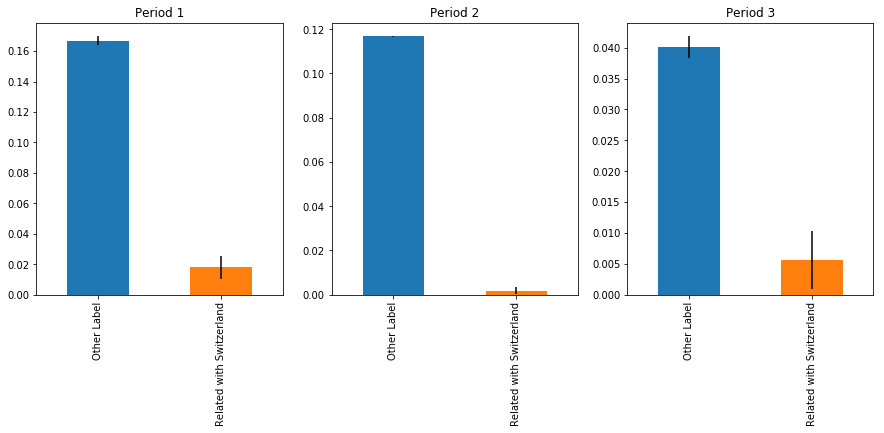

In [352]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["labCat"])-sum(foodSwitzerlandBef["labCat"]=="Switzerland")-sum(foodSwitzerlandBef["labCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandDur["labCat"])-sum(foodSwitzerlandDur["labCat"]=="Switzerland")-sum(foodSwitzerlandDur["labCat"]=="Other country")," products in the period 2.")
print("There was not information for ",len(foodSwitzerlandAft["labCat"])-sum(foodSwitzerlandAft["labCat"]=="Switzerland")-sum(foodSwitzerlandAft["labCat"]=="Other country")," products in the period 3.")

#Plot origin of primary resources by periods
plt.subplot(1,3,1)

xB = [foodSwitzerlandBef["labCat"].value_counts()[0], foodSwitzerlandBef["labCat"].value_counts()[1]]
xD = [foodSwitzerlandDur["labCat"].value_counts()[0], foodSwitzerlandDur["labCat"].value_counts()[1]]
xA = [foodSwitzerlandAft["labCat"].value_counts()[1], foodSwitzerlandAft["labCat"].value_counts()[0]]

(foodSwitzerlandBef["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,3,2)
(foodSwitzerlandDur["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SDstd,OCDstd],title='Period 2')
plt.subplot(1,3,3)
(foodSwitzerlandAft["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 3')

plt.show()

Median with NaN:  0.8085534971558975
Median without NaN:  nan


Text(0.5, 1.0, 'Pearson Corr. No Nan Switzerland origin and Other country manufacture origin')

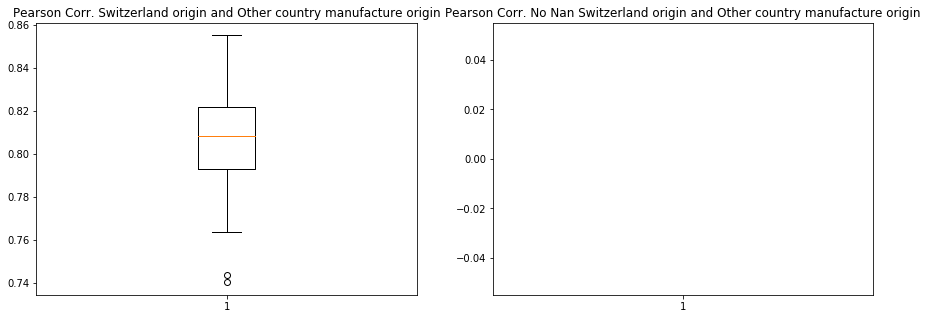

In [353]:
#Plot Correlation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplot(1,2,1)
print("Median with NaN: ",np.quantile(pearson_100ite,0.5))
plt.boxplot(pearson_100ite)
plt.title("Pearson Corr. Switzerland origin and Other country manufacture origin")

plt.subplot(1,2,2)
print("Median without NaN: ",np.quantile(pearsonNoNan_100ite,0.5))
plt.boxplot(pearsonNoNan_100ite)
plt.title("Pearson Corr. No Nan Switzerland origin and Other country manufacture origin")